In [1]:
RANDOM_STATE = 1234

In [2]:
import numpy as np
import pandas as pd
import torch
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.MPNN import MPNN
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
trn = pd.read_csv("../data/processed/trn.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")

trn_y, trn_X = trn["Solubility"], trn["SMILES"]
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC["SMILES"]
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC["SMILES"]
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC["SMILES"]

In [6]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_08SC_X = featurizer.convert(tst_08SC_X)
tst1_19SC_X = featurizer.convert(tst1_19SC_X)
tst2_19SC_X = featurizer.convert(tst2_19SC_X)

In [7]:
tune_space = {
    "node_out_feats": hp.choice("node_out_feats", [64, 128, 256]),
    "edge_hidden_feats": hp.choice("edge_hidden_feats", [64, 128, 256]),
    "num_step_message_passing": hp.randint("num_step_message_passing", 4, 8),
    "num_step_set2set": hp.randint("num_step_set2set", 4, 8),
    "num_layer_set2set": hp.randint("num_layer_set2set", 2, 6),
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "weight_decay": hp.uniform("weight_decay", 0, 1),
    "batch_size": 4096,
}

In [8]:
def tune_obj(space):
    model = MPNN(
        n_tasks=1,
        node_in_feats=featurizer.get_node_feat_size(),
        edge_in_feats=featurizer.get_edge_feat_size(),
        node_out_feats=space["node_out_feats"],
        edge_hidden_feats=space["edge_hidden_feats"],
        num_step_message_passing=space["num_step_message_passing"],
        num_step_set2set=space["num_step_set2set"],
        num_layer_set2set=space["num_layer_set2set"],
        lr=space["lr"],
        weight_decay=space["weight_decay"],
        batch_size=4096
    )
    model.fit(trn_X, trn_y, verbose=False, epochs=400)
    pred_19t1 = model.predict(tst1_19SC_X).cpu()
    pred_19t2 = model.predict(tst2_19SC_X).cpu()
    pred_08t = model.predict(tst_08SC_X).cpu()
    return {
        "loss": np.mean([
            mean_squared_error(tst1_19SC_y, pred_19t1, squared=False),
            mean_squared_error(tst2_19SC_y, pred_19t2, squared=False),
            mean_squared_error(tst_08SC_y, pred_08t, squared=False)]),
        'status': STATUS_OK
    }

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

In [ ]:
best_params

In [8]:
best_params = {
    "node_out_feats": 64,
    "edge_hidden_feats": 128,
    "num_step_message_passing": 6,
    "num_step_set2set": 6,
    "num_layer_set2set": 3,
    "lr": 0.01,
    "weight_decay": 0.0042748880398552624,
    "batch_size": 4096,
}

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pred_19t1, pred_19t2, pred_08t = [], [], []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X[trn_idx], trn_X[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]

    model = MPNN(
        n_tasks=1,
        node_in_feats=featurizer.get_node_feat_size(),
        edge_in_feats=featurizer.get_edge_feat_size(),
        node_out_feats=best_params["node_out_feats"],
        edge_hidden_feats=best_params["edge_hidden_feats"],
        num_step_message_passing=best_params["num_step_message_passing"],
        num_step_set2set=best_params["num_step_set2set"],
        num_layer_set2set=best_params["num_layer_set2set"],
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        batch_size=4096
    )

    scores = model.fit(tX, ty, val_X=vX, val_y=vy, epochs=800, min_epochs=500, early_stop_epochs=10)

    pred_19t1.append(model.predict(tst1_19SC_X).cpu())
    pred_19t2.append(model.predict(tst2_19SC_X).cpu())
    pred_08t.append(model.predict(tst_08SC_X).cpu())

[DEVICE] cuda


 65%|██████▌   | 523/800 [01:49<00:58,  4.77it/s, trn_loss:0.241 val_loss:0.336 rmse:0.913 r2:0.785] 


[DEVICE] cuda


 65%|██████▌   | 521/800 [01:47<00:57,  4.84it/s, trn_loss:0.303 val_loss:0.342 rmse:0.901 r2:0.793]


[DEVICE] cuda


 68%|██████▊   | 548/800 [01:52<00:51,  4.88it/s, trn_loss:0.267 val_loss:0.317 rmse:0.862 r2:0.787]


[DEVICE] cuda


 69%|██████▉   | 554/800 [01:53<00:50,  4.86it/s, trn_loss:0.316 val_loss:0.334 rmse:0.904 r2:0.768]


[DEVICE] cuda


 66%|██████▌   | 526/800 [01:47<00:56,  4.88it/s, trn_loss:0.304 val_loss:0.456 rmse:1.076 r2:0.744]


In [22]:
pred_19t1 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t1, 1)]
pred_19t2 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t2, 1)]
pred_08t = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_08t, 1)]

In [23]:
performance = {
    "2019SC TST1 (RMSE)": mean_squared_error(tst1_19SC_y, pred_19t1, squared=False),
    "2019SC TST2 (RMSE)": mean_squared_error(tst2_19SC_y, pred_19t2, squared=False),
    "2008SC TST  (RMSE)": mean_squared_error(tst_08SC_y, pred_08t, squared=False),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y, pred_19t2),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y, pred_08t),
}
performance

{'2019SC TST1 (RMSE)': 0.8578550784365248,
 '2019SC TST2 (RMSE)': 1.770899715242112,
 '2008SC TST  (RMSE)': 1.062298431762202,
 '2019SC TST1 (R^2)': 0.39390224815267805,
 '2019SC TST2 (R^2)': 0.22044702570408747,
 '2008SC TST  (R^2)': 0.38723770541052005}

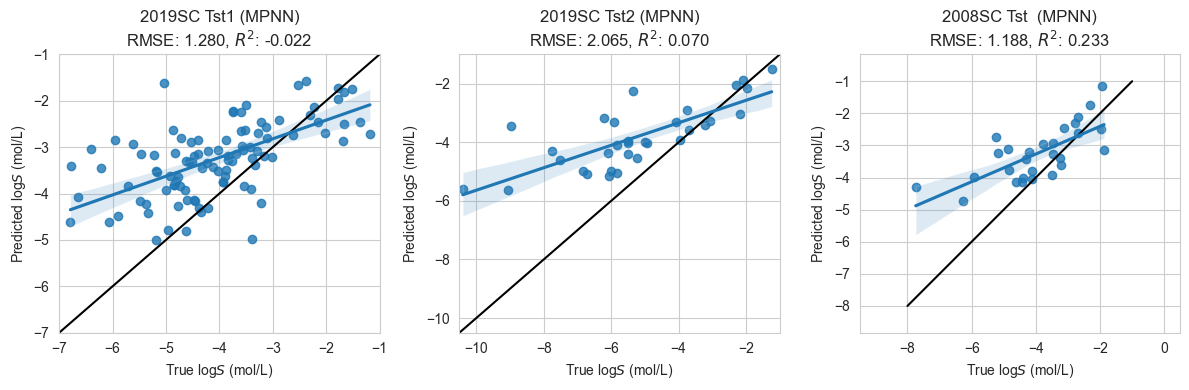

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "MPNN"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -10.5, -1
min_ax3, max_ax3 = -8, -1

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")
sns.lineplot(x=[min_ax3, max_ax3], y=[min_ax3, max_ax3], ax=ax3, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst1_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t1
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst2_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t2
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax2
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst_08SC_y.values,
        "Predicted log$S$ (mol/L)": pred_08t
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax3
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)
ax3.set_xlim(min_ax3, max_ax3)
ax3.set_ylim(min_ax3, max_ax3)

ax1.set_title(f"2019SC Tst1 ({model_name})\n"
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"2019SC Tst2 ({model_name})\n"
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"2008SC Tst  ({model_name})\n"
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

plt.axis("equal")
plt.tight_layout()